From Shilpi: https://github.com/Shilpi96/ilofar_stix_project/blob/main/nrh_analysis/create_nrh_image.py

In [1]:
from astropy.io import fits
from astropy import units as u 
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from scipy.io import readsav
from sunpy.coordinates import frames
import numpy as np
import pandas as pd
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize, SqrtStretch
from matplotlib import colors
# import pdb # Python Debugger

In [2]:
#  Read nrh data
pathdir = '../data/nrh'
filename = 'nrh_maps_210918_081800_090654_228_0.sav'

nrh = readsav(f'{pathdir}/{filename}', python_dict=True)
# pdb.set_trace()

In [3]:
nrh.keys()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


dict_keys(['nrh_data', 'nrh_hdr'])

In [4]:
b = {name:nrh['nrh_hdr'][name][0] for name in nrh['nrh_hdr'].dtype.names} # getting header info for the first time index
# pdb.set_trace()

In [5]:
nrh['nrh_hdr']['DATE_OBS'], nrh['nrh_hdr']['DATE_OBS'].shape

(array([b'2021-09-18T08:18:00.200Z', b'2021-09-18T08:18:00.450Z',
        b'2021-09-18T08:18:00.700Z', ..., b'2021-09-18T09:06:54.200Z',
        b'2021-09-18T09:06:54.450Z', b'2021-09-18T09:06:54.700Z'],
       dtype=object),
 (11739,))

In [6]:
nrh['nrh_hdr']['DATE_OBS'][1], nrh['nrh_hdr']['DATE_OBS'][0]

(b'2021-09-18T08:18:00.450Z', b'2021-09-18T08:18:00.200Z')

In [7]:
nrh['nrh_data'].shape

(11739, 128, 128)

In [8]:
map_data = nrh['nrh_data'][0]

ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                     )

header = sunpy.map.make_fitswcs_header(map_data,
                                       ref_coord,
                                       reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                       scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                       wavelength=float(b['FREQ'])*u.MHz)

nrh_map = sunpy.map.Map(map_data, header)
# pdb.set_trace()

In [9]:
nrh_map.meta

MetaDict([('wcsaxes': '2')
('crpix1': '64.0')
('crpix2': '64.0')
('cdelt1': '29.90763282775879')
('cdelt2': '29.90763282775879')
('cunit1': 'arcsec')
('cunit2': 'arcsec')
('ctype1': 'HPLN-TAN')
('ctype2': 'HPLT-TAN')
('crval1': '0.0')
('crval2': '0.0')
('lonpole': '180.0')
('latpole': '0.0')
('mjdref': '0.0')
('date-obs': '2021-09-18T08:18:00.200')
('rsun_ref': '695700000.0')
('dsun_obs': '150313987027.05')
('hgln_obs': '0.0')
('hglt_obs': '7.1501553250837')
('wavelnth': '228.0')
('waveunit': 'MHz')
('naxis': '2')
('naxis1': '128')
('naxis2': '128')
('pc1_1': '1.0')
('pc1_2': '-0.0')
('pc2_1': '0.0')
('pc2_2': '1.0')
('rsun_obs': '954.6612452304431')])

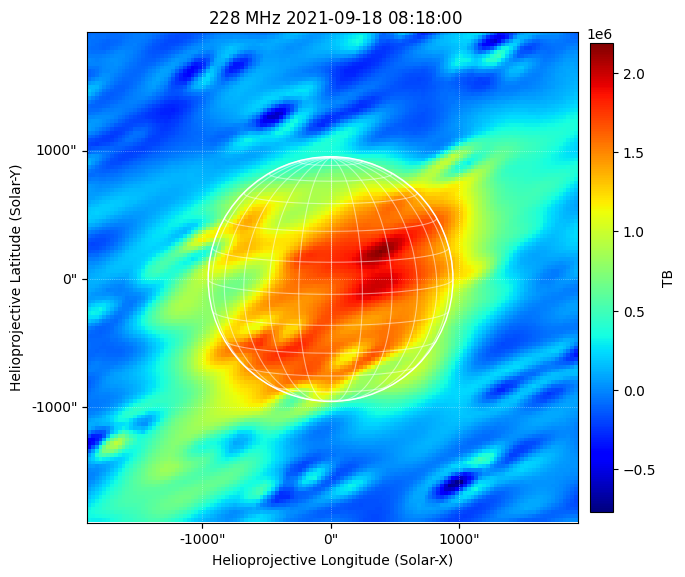

In [10]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, cmap='jet') # viridis, plasma, inferno, jet, hsv_r
nrh_map.draw_limb(color='w')
nrh_map.draw_grid(color='w')
# ax.text(3, nrh_map.data.shape[1]-7, f"{nrh_map.meta['wavelnth']} {nrh_map.meta['waveunit']}", color='white', fontsize=12, fontweight='bold')
fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
fig.tight_layout()
plt.show()

In [11]:
# for name in nrh['nrh_hdr'].dtype.names:
#     print(name, nrh['nrh_hdr'][name][0])

Plot all images and make animation

In [12]:
headers_list = []
images_list = []

for i in range(len(nrh['nrh_hdr'])):
    b = {name:nrh['nrh_hdr'][name][i] for name in nrh['nrh_hdr'].dtype.names} # getting header info for the i-th time index
    headers_list.append(b)
    m = nrh['nrh_data'][i] # getting image info for the i-th time index
    images_list.append(m)

In [13]:
nrh_maps = []

for b, map_data in zip(headers_list, images_list):
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                        frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                        )

    header = sunpy.map.make_fitswcs_header(map_data,
                                        ref_coord,
                                        reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                        scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                        wavelength=float(b['FREQ'])*u.MHz)

    nrh_map = sunpy.map.Map(map_data, header)
    nrh_maps.append(nrh_map)

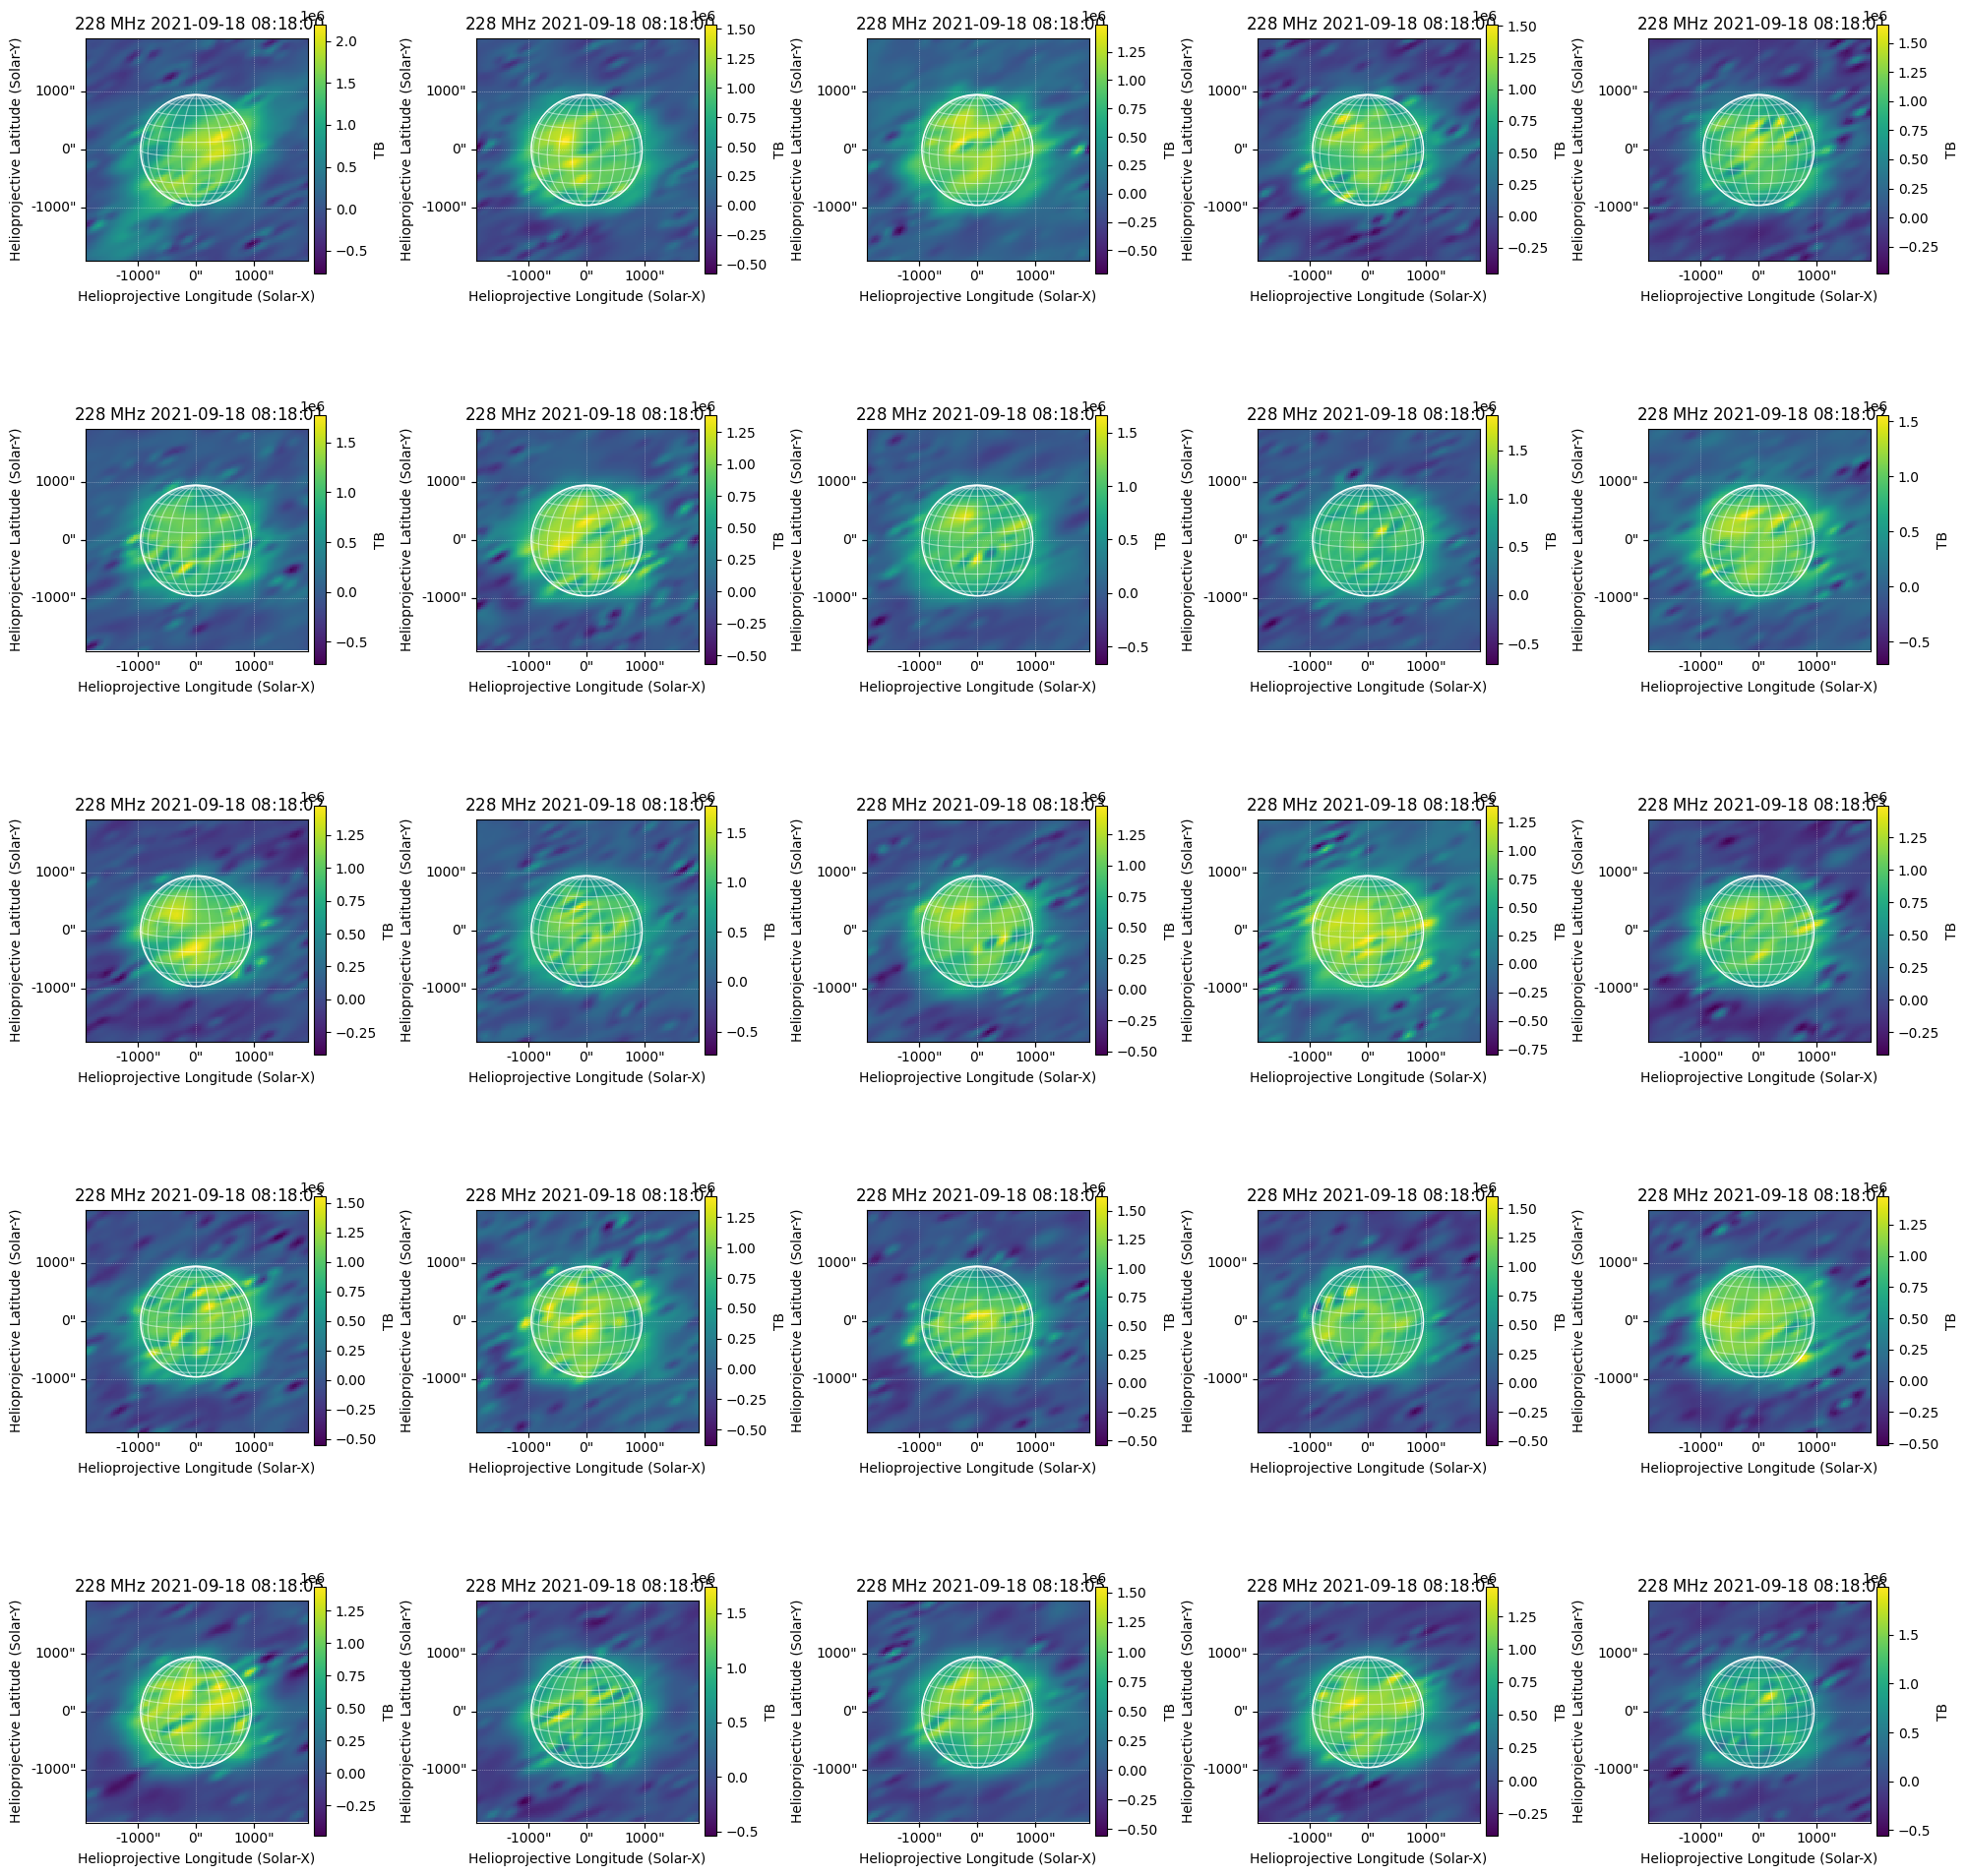

In [14]:
fig = plt.figure(figsize=[20,20])

for i, nrh_map in enumerate(nrh_maps[:25]):
    ax = fig.add_subplot(5,5,i+1, projection=nrh_map)
    img = nrh_map.plot(axes=ax, cmap='viridis')
    nrh_map.draw_limb(color='w')
    nrh_map.draw_grid(color='w')
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))

fig.tight_layout()
plt.show()

Export each image individually

In [16]:
pathdir = r'D:\Study\Academic\Research\PostDoc_work\DIAS_Fellowship_2024\Work\plots\nrh'

for i, nrh_map in enumerate(nrh_maps[1253:]):
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=nrh_map)
    img = nrh_map.plot(axes=ax, cmap='jet')
    nrh_map.draw_limb(color='w')
    nrh_map.draw_grid(color='w')
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
    fig.tight_layout()
    fig.savefig(f"{pathdir}/{nrh_map.meta['wavelnth']}_{nrh_map.meta['waveunit']}_{nrh_map.meta['date-obs'].replace(':','_')}.png",
                format='png', dpi=100, bbox_inches='tight')
    plt.close()
    print(f"{nrh_map.meta['date-obs']} has been exported.")

2021-09-18T08:23:13.450 has been exported.
2021-09-18T08:23:13.700 has been exported.
2021-09-18T08:23:13.950 has been exported.
2021-09-18T08:23:14.200 has been exported.
2021-09-18T08:23:14.450 has been exported.
2021-09-18T08:23:14.700 has been exported.
2021-09-18T08:23:14.950 has been exported.
2021-09-18T08:23:15.200 has been exported.
2021-09-18T08:23:15.450 has been exported.
2021-09-18T08:23:15.700 has been exported.
2021-09-18T08:23:15.950 has been exported.
2021-09-18T08:23:16.200 has been exported.
2021-09-18T08:23:16.450 has been exported.
2021-09-18T08:23:16.700 has been exported.
2021-09-18T08:23:16.950 has been exported.
2021-09-18T08:23:17.200 has been exported.
2021-09-18T08:23:17.450 has been exported.
2021-09-18T08:23:17.700 has been exported.
2021-09-18T08:23:17.950 has been exported.
2021-09-18T08:23:18.200 has been exported.
2021-09-18T08:23:18.450 has been exported.
2021-09-18T08:23:18.700 has been exported.
2021-09-18T08:23:18.950 has been exported.
2021-09-18T

KeyboardInterrupt: 